In [5]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

# 1. Завантаження датасету
dataset_path = "/kaggle/input/initial-dataset/dataset"
img_size = (299, 299)
batch_size = 32

train_ds = image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# 2. Нормалізація
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# 3. Побудова базової моделі
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Спочатку заморожуємо

# 4. Додаємо класифікатор
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 класи

model = Model(inputs=base_model.input, outputs=predictions)

# 5. Компіляція моделі
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# 7. Початкове навчання (заморожена база)
model.fit(train_ds, epochs=10, callbacks=[early_stopping])

# 8. Fine-Tuning: розморожуємо верхні 50 шарів базової моделі
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# 9. Повторна компіляція з меншою швидкістю навчання
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# 10. Донавчання моделі з розмороженими шарами
model.fit(train_ds, epochs=30, callbacks=[early_stopping])

# 11. Збереження моделі
model.save("cat_breed_classifier_finetuned.h5")


Found 300 files belonging to 3 classes.
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3233 - loss: 1.6280
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6278 - loss: 0.8584
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7654 - loss: 0.6175
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7959 - loss: 0.5361
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8256 - loss: 0.4672
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8950 - loss: 0.3728
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9166 - loss: 0.3377
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9244 - loss: 0.2752
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9299 - loss: 0.2595
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8898 - loss: 0.2924
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8242 - loss: 0.3968
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


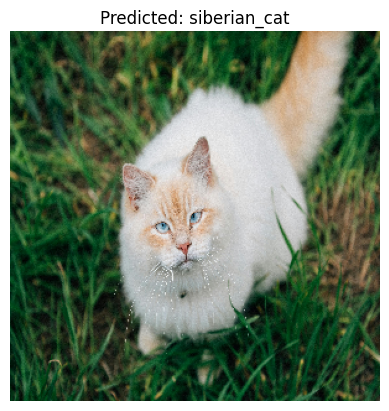

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


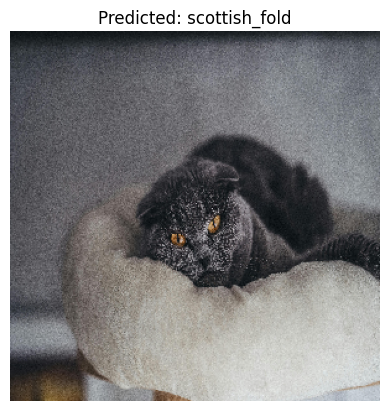

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


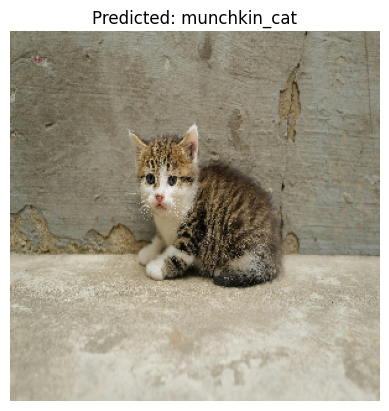

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


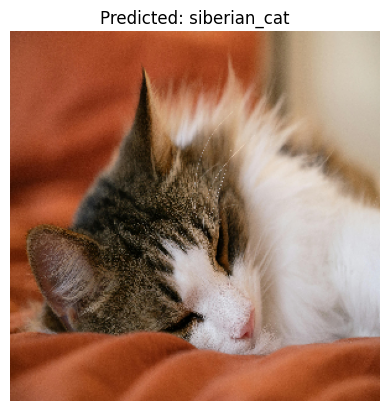

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


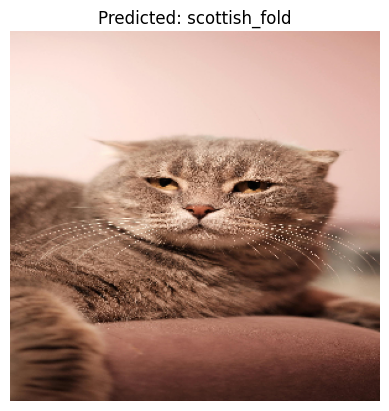

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


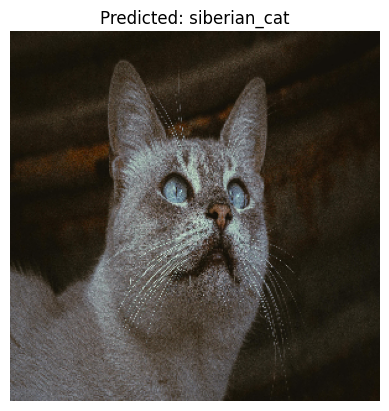

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


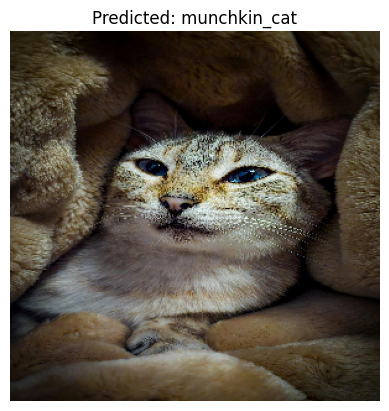

In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1. Завантаження моделі
model = load_model("/kaggle/input/inception-v3-cat-breed-classifier-h5/cat_breed_classifier_finetuned.h5")

# 2. Назви класів (у тій самій послідовності, як і у вашій папці)
class_names = ['munchkin_cat', 'scottish_fold', 'siberian_cat']

# 3. Завантажити зображення для аналізу
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Нормалізація
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Показати зображення і результат
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

# Приклад використання
predict_image("/kaggle/input/initial-dataset/dataset/siberian_cat/siberian_img_17.jpeg")
predict_image("/kaggle/input/initial-dataset/dataset/scottish_fold/scottish_img_17.jpeg")
predict_image("/kaggle/input/initial-dataset/dataset/munchkin_cat/munchkin_img_17.jpeg")
predict_image("/kaggle/input/initial-dataset/dataset/siberian_cat/siberian_img_20.jpeg")
predict_image("/kaggle/input/initial-dataset/dataset/scottish_fold/scottish_img_20.jpeg")
predict_image("/kaggle/input/initial-dataset/dataset/siberian_cat/siberian_img_55.jpeg")
predict_image("/kaggle/input/initial-dataset/dataset/munchkin_cat/munchkin_img_20.jpeg")
